In [1]:
#!pip install yfinance

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
sp500stocks = pd.read_csv("SP500.csv", header=None)

In [16]:
sectors = sp500stocks[1].unique().tolist()

In [17]:
sectors.remove('Real Estate')

In [18]:
sectors

['Industrials',
 'Health Care',
 'Information Technology',
 'Communication Services',
 'Consumer Staples',
 'Consumer Discretionary',
 'Utilities',
 'Financials',
 'Materials',
 'Energy']

In [404]:
def get_sector_stocks(sector_name, df):
    return df.loc[df[1] == sector_name, 0].tolist()

def get_sector_returns(sector_stocks):
    prices = yf.download(sector_stocks, start="2006-01-01", end="2022-11-20")['Adj Close']
    returns = prices.dropna(axis=1).resample('W').last().pct_change().fillna(0)
    log_returns = returns.apply(np.log1p)
    return returns, log_returns

sector_etfs = { 'Materials' : 'XLB', 'Communication Services' : 'XLC', 'Consumer Discretionary' : 'XLY',
                'Consumer Staples' : 'XLP', 'Energy' : 'XLE', 'Financials' : 'XLF',
                'Health Care' : 'XLV', 'Industrials' : 'XLI', 'Information Technology' : 'XLK', 'Utilities' : 'XLU' }

In [405]:
returns = {}
log_returns = {}

for sector in sectors:
    stocks = get_sector_stocks(sector, sp500stocks)
    r, lr = get_sector_returns(stocks)
    returns[sector] = r
    log_returns[sector] = lr

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  64 of 64 completed
[*********************100%***********************]  75 of 75 completed
[*********************100%***********************]  25 of 25 completed
[*********************100%***********************]  32 of 32 completed
[*********************100%***********************]  56 of 56 completed
[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  66 of 66 completed
[*********************100%***********************]  28 of 28 completed
[*********************100%***********************]  23 of 23 completed


In [406]:
spy_prices = yf.download(['SPY'], start="2006-01-01", end="2022-11-20")['Adj Close']
spy_returns = spy_prices.resample('W').last().pct_change().fillna(0)

[*********************100%***********************]  1 of 1 completed


In [407]:
sector_returns = None

for sector in sector_etfs:
    prices = yf.download(sector_etfs[sector], start="2006-01-01", end="2022-11-20")['Adj Close']
    r = prices.resample('W').last().pct_change().fillna(0)
    r.name = sector
    if sector_returns is None:
        sector_returns = r.to_frame()
    else:
        sector_returns[sector] = r

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1017]:
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings
from sklearn.covariance import EmpiricalCovariance as EC
from sklearn.preprocessing import StandardScaler

def checkDesignMatrix(X):
    try:
        assert isinstance(X, (np.ndarray, pd.DataFrame, pd.Series))
    except AssertionError:
        raise
        sys.exit(1)

    X = np.asarray(X, dtype=float)
    X = np.atleast_2d(X)
    T, N = X.shape
    transpose_flag = False
    return T, N, transpose_flag
        
        
def marcenkoPastur(X):
    T, N, _ = checkDesignMatrix(X)
    q = N / float(T)

    lambda_min = (1 - np.sqrt(q))**2
    lambda_max = (1 + np.sqrt(q))**2

    def rho(x):
        ret = np.sqrt((lambda_max - x) * (x - lambda_min))
        ret /= 2 * np.pi * q * x
        return ret if lambda_min < x < lambda_max else 0.0

    return (lambda_min, lambda_max), rho


def clipped(X, alpha=None, return_covariance=False):
    try:
        if alpha is not None:
            assert isinstance(alpha, Real) and 0 <= alpha <= 1
            
        assert isinstance(return_covariance, bool)
    except AssertionError:
        raise
        sys.exit(1)
    
    T, N, transpose_flag = checkDesignMatrix(X)
    if transpose_flag:
        X = X.T
        
    if not return_covariance:
        X = StandardScaler(with_mean=False,
                           with_std=True).fit_transform(X)

    ec = EC(store_precision=False,
                             assume_centered=True)
    ec.fit(X)
    E = ec.covariance_
    
    if return_covariance:
        inverse_std = 1./np.sqrt(np.diag(E))
        E *= inverse_std
        E *= inverse_std.reshape(-1, 1)

    eigvals, eigvecs = np.linalg.eigh(E)
    eigvecs = eigvecs.T

    if alpha is None:
        (lambda_min, lambda_max), _ = marcenkoPastur(X)
        xi_clipped = np.where(eigvals >= lambda_max, eigvals, np.nan)
    else:
        xi_clipped = np.full(N, np.nan)
        threshold = int(ceil(alpha * N))
        if threshold > 0:
            xi_clipped[-threshold:] = eigvals[-threshold:]

    gamma = float(E.trace() - np.nansum(xi_clipped))
    gamma /= np.isnan(xi_clipped).sum()
    xi_clipped = np.where(np.isnan(xi_clipped), gamma, xi_clipped)

    E_clipped = np.zeros((N, N), dtype=float)
    for xi, eigvec in zip(xi_clipped, eigvecs):
        eigvec = eigvec.reshape(-1, 1)
        E_clipped += xi * eigvec.dot(eigvec.T)
        
    tmp = 1./np.sqrt(np.diag(E_clipped))
    E_clipped *= tmp
    E_clipped *= tmp.reshape(-1, 1)
    
    if return_covariance:
      std = 1./inverse_std
      E_clipped *= std
      E_clipped *= std.reshape(-1, 1)

    return E_clipped

In [1283]:
from scipy.sparse.csgraph import connected_components
import scipy as sp

def graph_entropy(C, cutoff):
    C = (np.abs(C)> cutoff).astype(int)
    # graph entropy
    _, labels = connected_components(C)
    counts = np.unique(labels, return_counts=True)[1]
    probs = counts / np.sum(counts)
    if len(counts) > 1:
        entropy = sp.stats.entropy(probs) / np.log(len(counts))
    else:
        entropy = 0.0
    return entropy    

def structural_entropy(df, lags):
    entropy_df = pd.DataFrame(index=df.index)
    
    for i in tqdm(range(max(lags), df.shape[0])):
        for lag in lags:
            X = df.iloc[i-lag:i+1] # i+1 because it is exclusive
            C = clipped(X.values)
            mr = X.sum(axis=0).mean()
            
            if mr >= 0:
                entropy_df.loc[df.index[i], str(lag)] = graph_entropy(C, 0.6)
            else:
                entropy_df.loc[df.index[i], str(lag)] = -graph_entropy(C, 0.6)
    return entropy_df

In [1291]:
entropy_df = {}

for sector in sectors:
    entropy_df[sector] = structural_entropy(log_returns[sector], lags=[60, 50, 40, 30])

100%|███████████████████████████████████████████████████████████████████████████████| 821/821 [00:06<00:00, 131.06it/s]


In [1292]:
signals = {}

for sector in sectors:
    entropy_mean = entropy_df[sector].dropna(axis=0).diff(axis=1).dropna(axis=1)
    signal = entropy_mean.mean(axis=1).divide(entropy_mean.std(axis=1))
    signals[sector] = signal
    signals[sector].name = sector

In [1293]:
dsigs = {}

for sector in sectors:
    dsigs[sector] = signals[sector]
    dsigs[sector].name = sector

signals_df = pd.concat(list(dsigs.values()), join='inner', axis=1)
signals_df.shape

(821, 10)

In [1318]:
weights = np.zeros(signals_df.shape)
weights = pd.DataFrame(weights, index=signals_df.index, columns=signals_df.columns)


for i in range(0, signals_df.shape[0]):
    e = signals_df.iloc[i, :]
    e.replace([np.inf, -np.inf], np.nan, inplace=True)
    e = e.dropna(axis=0)
    pe = e[e > 0]
    ne = e[e < 0]
    
    if len(pe) > 0 and len(ne) > 0:
        weights.loc[signals_df.index[i], pe.nlargest(1).index] =  1
        weights.loc[signals_df.index[i], ne.nsmallest(1).index] = -1

In [1319]:
port_ret = weights.shift(1).multiply(sector_returns)

<AxesSubplot:xlabel='Date'>

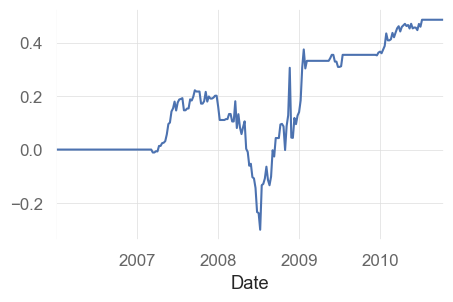

In [1322]:
pnl = port_ret.sum(axis=1).iloc[0:250]
pnl.cumsum(axis=0).plot(figsize=(5, 3))

                           Strategy
-------------------------  ----------
Start Period               2006-01-08
End Period                 2010-10-17
Risk-Free Rate             0.0%
Time in Market             49.0%

Cumulative Return          40.05%
CAGR﹪                     7.31%

Sharpe                     0.91
Prob. Sharpe Ratio         80.89%
Smart Sharpe               0.73
Sortino                    1.29
Smart Sortino              1.04
Sortino/√2                 0.91
Smart Sortino/√2           0.74
Omega                      1.3

Max Drawdown               -42.51%
Longest DD Days            420
Volatility (ann.)          53.92%
Calmar                     0.17
Skew                       -0.85
Kurtosis                   19.89

Expected Daily %           0.13%
Expected Monthly %         0.58%
Expected Yearly %          6.97%
Kelly Criterion            13.94%
Risk of Ruin               0.0%
Daily Value-at-Risk        -5.39%
Expected Shortfall (cVaR)  -5.39%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-09-30,2008-07-13,2008-11-23,420,-42.505122,-38.676714
2,2008-11-30,2008-12-07,2009-01-25,56,-26.162329,-26.087368
3,2009-02-01,2009-02-01,2010-01-24,357,-7.097123,-6.666029
4,2007-08-05,2007-08-05,2007-09-16,42,-4.539693,-3.919942
5,2007-07-01,2007-07-01,2007-07-15,14,-3.337078,-0.448088


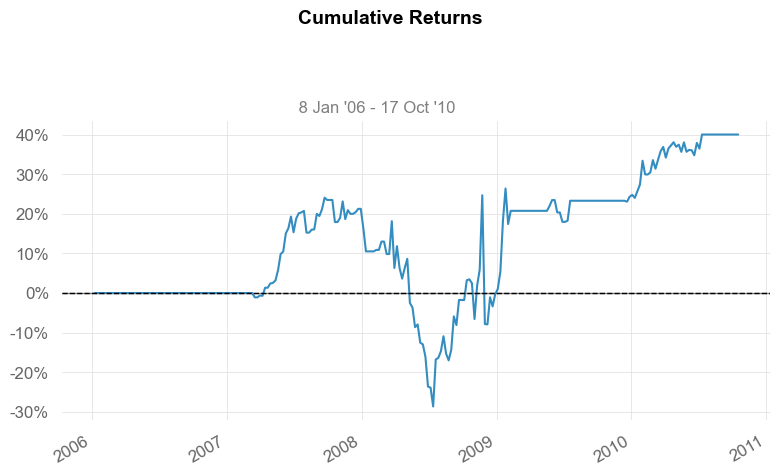

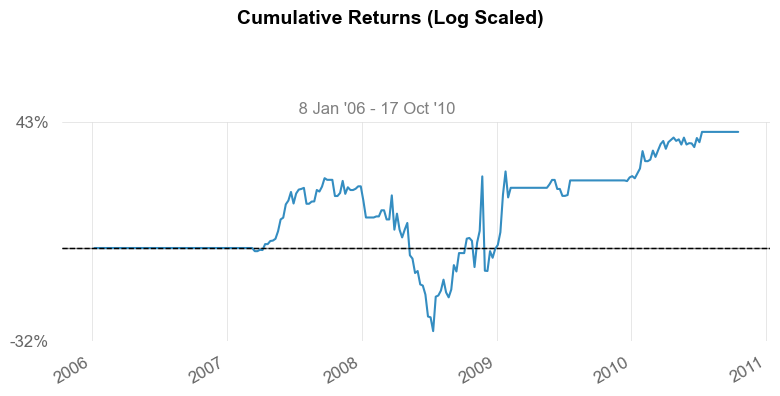

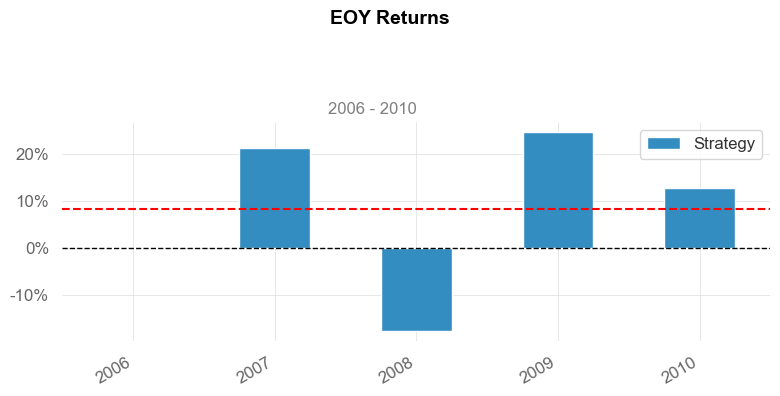

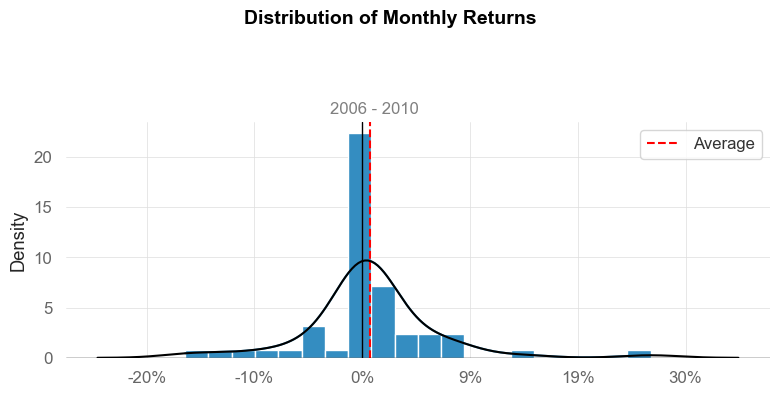

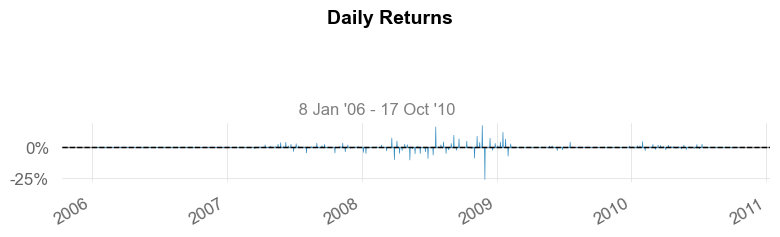

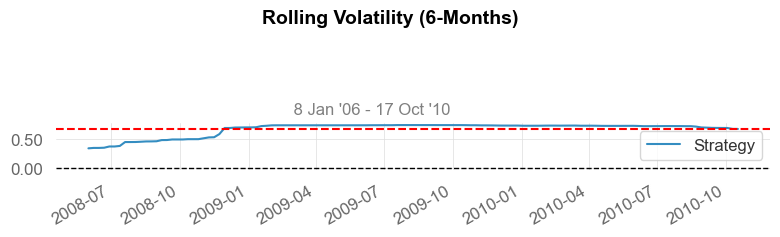

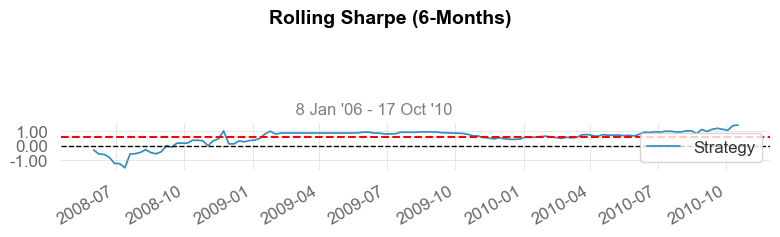

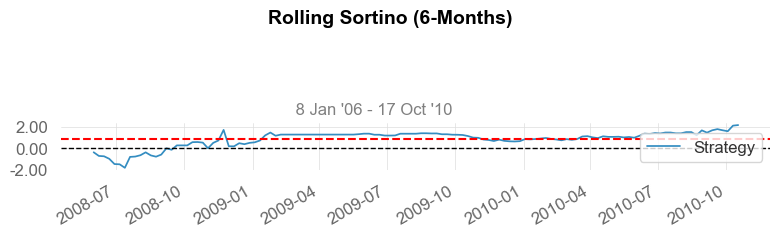

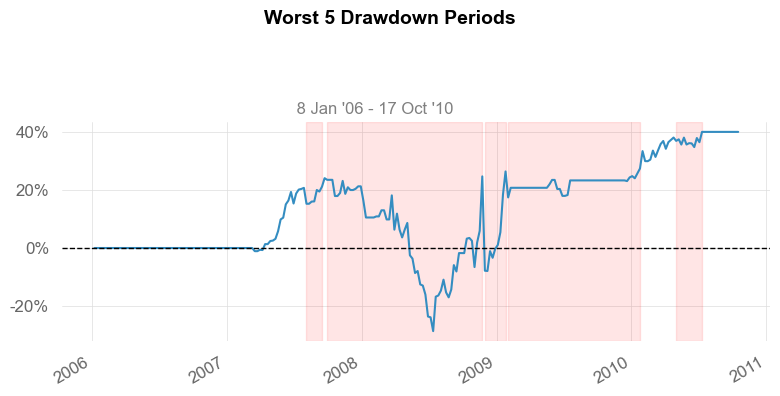

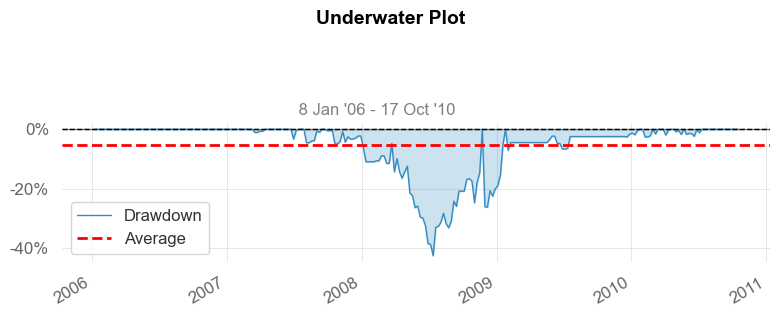

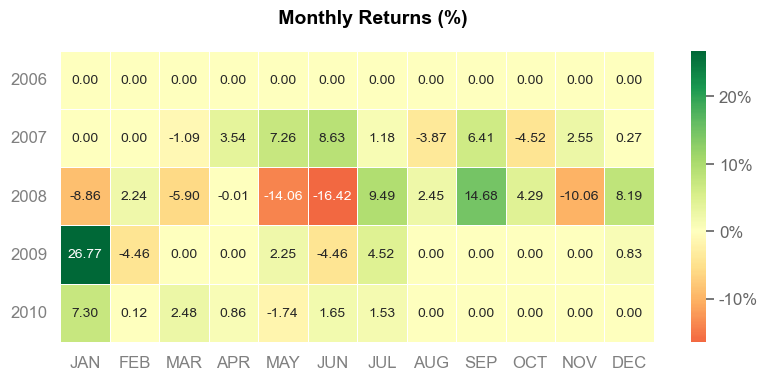

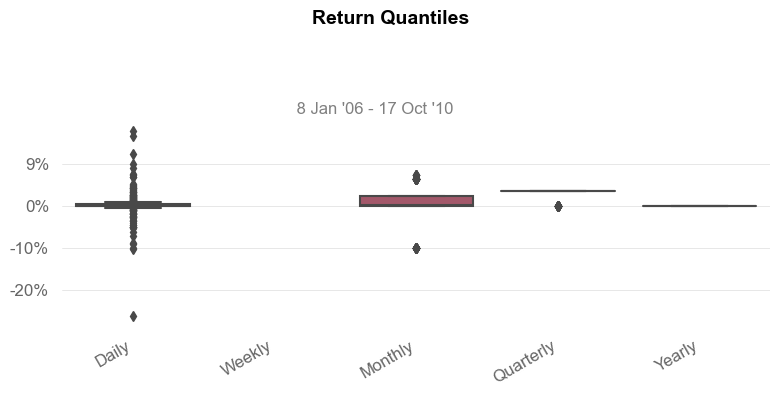

In [1323]:
import quantstats as qs
qs.reports.full(pnl)

#### Things to do

1. Fetch US Sector futures data (rolling)
2. Fetch US Sector future underlying weights
3. Multiply returns by weight before computing correlations and entropy
4. Try different cutoffs for entropy (0.6, 0.7, 0.8)